In [5]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [52]:
data = {"n":[3,None,2],"i":[3,2,4],"o":[6,7,8]}
df1 = pd.DataFrame(data,index=["x","y","z"])
df1

,n,i,o
x,3.0,3,6
y,NaN,2,7
z,2.0,4,8


In [35]:
dicc = {}
for i in ["h","u","t","l"]:
    dicc[i] = []
dicc

{'h': [], 'u': [], 't': [], 'l': []}

In [39]:
df_titanic = pd.read_csv("titanic.csv")
df_titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [73]:
np.issubdtype(df_titanic["pclass"].dtype,np.number)

True

In [95]:
def describe_df(df):
    columnas = df.columns.to_list()
    dicc = {}
    for col in columnas:
        dicc[col] = []
        dicc[col].append(df[col].dtype)
        dicc[col].append(df[col].isna().sum() / len(df) * 100)
        verificar_si_es_numerico = np.issubdtype(df[col].dtype,np.number)
        if (verificar_si_es_numerico):
            dicc[col].append("Yes" if np.isinf(df[col]).any() else "No")
        else:
            dicc[col].append("No")
        dicc[col].append(df[col].nunique())
        dicc[col].append(df[col].nunique() / len(df))
    df_return  = pd.DataFrame(dicc,index=["DATA_TYPE","MISSINGS (%)","VALORES_INFINITOS","UNIQUE_VALUES","CARDIN (%)"])
    return df_return

In [96]:
describe_df(df_titanic)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool
MISSINGS (%),0.0,0.0,0.0,19.86532,0.0,0.0,0.0,0.224467,0.0,0.0,0.0,77.216611,0.224467,0.0,0.0
VALORES_INFINITOS,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
UNIQUE_VALUES,2,3,2,88,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.002245,0.003367,0.002245,0.098765,0.007856,0.007856,0.278339,0.003367,0.003367,0.003367,0.002245,0.007856,0.003367,0.002245,0.002245


In [55]:
def tipifica_variables(df,umbral_categoria,umbral_continua):
    dicc = {
        "nombre_variable":[],
        "tipo_sugerido":[]
    }
    for i in df.columns:
        val_unicos = df[i].nunique()
        cardinalidad = val_unicos /len(df) * 100
        dicc["nombre_variable"].append(i)
        if val_unicos == 2:
            dicc["tipo_sugerido"].append("Binario")
        elif cardinalidad < umbral_categoria:
            dicc["tipo_sugerido"].append("Categorica")
        elif cardinalidad < umbral_continua:
            dicc["tipo_sugerido"].append("Nª Discreta")  
        else:
            dicc["tipo_sugerido"].append("Nª Continua")
    return pd.DataFrame(dicc)

In [57]:
tipifica_variables(df_titanic,10,20)

,nombre_variable,tipo_sugerido
0,survived,Binario
1,pclass,Categorica
2,sex,Binario
3,age,Categorica
4,sibsp,Categorica
5,parch,Categorica
6,fare,Nª Continua
7,embarked,Categorica
8,class,Categorica
9,who,Categorica


In [ ]:
def get_features_num_regression(df,target_col,umbral_corr,pvalue=None,mostrar=False):
    """
    Conseguir la lista de features que tienen gran impacto en la target.
    Argumentos:
        df:DataFrame que se pasa de entrada
        target_col:la variable target con el que se quiere analizar,tiene que ser numerico
        umbral_corr: Umbral minimo para considerar una variable importante para el modelo
        pvalue: Certeza estadística con la que queremos validar la importancia de las feature
    Returns:
        Lista:Lista de features importantes.
        Mostrar: Muestra la matriz de correlación en una grafica HeatMap.
    """
    if target_col not in df.columns:
        raise ValueError(f"Columna target {target_col} no esta en el DataFrame dado.")
    if not isinstance(df, pd.DataFrame):
        raise TypeError("El dato de entrada tiene que ser un DataFrame.")
    
    if umbral_corr < 0 or umbral_corr > 1:
        raise ValueError("Umbral de correlacion tiene que estar entre 0 y 1")
    if pvalue is not None and (pvalue < 0 or pvalue > 1):
        raise ValueError("P-value tiene que estar entre 0 y 1")

    if not (np.issubdtype(df[target_col].dtype,np.number)):
        raise TypeError(f"Columna target {target_col} tiene que ser numerico amigo")
    
    cardinalidad_target = df[target_col].nunique() / len(df) * 100
    if cardinalidad_target < 10:
        warnings.warn(f"Columna target {target_col} tiene poca cardinalidad ({cardinalidad_target:.2f}%).")
    if cardinalidad_target > 95:
        warnings.warn(f"Columna target {target_col} tiene mucha cardinalidad ({cardinalidad_target:.2f}%).")
    if cardinalidad_target == 100:
        raise ValueError(f"Columna target {target_col} tiene 100% cardinalidad.")

    if df[target_col].isnull().sum() > 0:
        raise ValueError(f"Columna target {target_col} tiene valores Nulos.")
    
    corr = df.corr(numeric_only=True)[target_col]
    if mostrar:
        plt.figure(figsize=(10,6))
        sns.heatmap(df.corr(numeric_only=True),annot=True, cmap='coolwarm', center=0)
        plt.title(f"Correlation heatmap for {target_col}")
        plt.show()
    
    corr = corr[abs(corr) > umbral_corr]
    corr = corr.drop(target_col)
    lista = []
    if pvalue is not None:
        pvalues = []
        for col in corr.index:
            _, p = pearsonr(df[target_col], df[col])
            if p < pvalue:
                lista.append(col)
    return lista

In [90]:
isinstance(df_titanic["survived"].dtype,np.number)

False

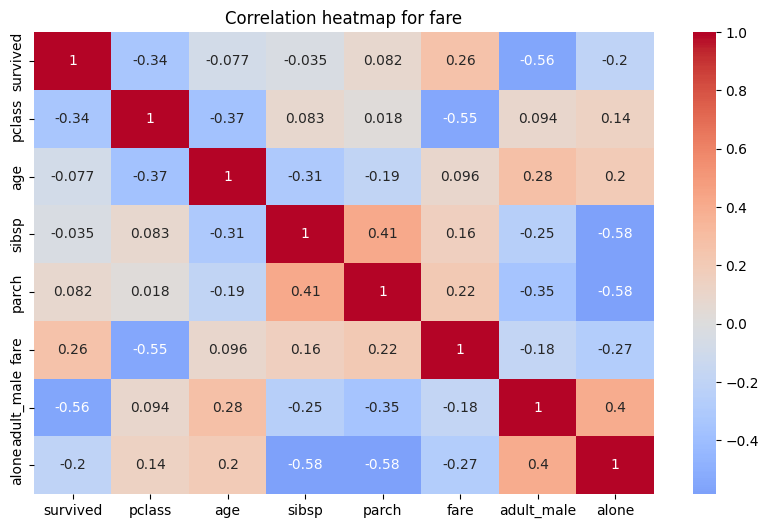

['survived', 'pclass', 'parch', 'alone']

In [97]:
get_features_num_regression(df_titanic,target_col="fare",umbral_corr=0.2,pvalue=0.05,mostrar=True)

In [ ]:
def plot_features_cat_regression(df,target_col="",columns=[],pvalue=0.05,with_individual_plot=False):
    if len(columns) >0:
        fig,axs = plt.subplots(len(columns),1,figsize=(15,10))
        for i in columns:
            sns.histplot(df[i],kde=True,hue=target_col)